In [1]:
%pip install langdetect googletrans==4.0.0-rc1

In [2]:
%pip install keras
%pip install unidecode

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import string
import regex as re
from unidecode import unidecode
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from keras.losses import sparse_categorical_crossentropy
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split

In [5]:
reviews = pd.read_parquet("/content/drive/MyDrive/Colab Notebooks/filtered_df.parquet")

In [6]:
reviews

,clean_text,category
1507650,Good. The game came in intact and new. Love th...,1.0
854753,am not sure,0.0
570816,it gets tangled so bad I cant even wear it.,-1.0
1023328,Very nice necklace and great buy!,1.0
2390332,Not all of the videos mentioned the connection...,-1.0
...,...,...
1100189,This is a continuation of the myst series. For...,1.0
224162,"After playing Cata for about a month, I gave u...",1.0
2278032,The only reason I gave it one star is because ...,-1.0
1603791,This was a great choice. It came with all my e...,1.0


In [7]:
df_eua = reviews.copy()

In [8]:
import random
def assign_review_score(label):
    if label == -1:
        return random.randint(1, 3)
    elif label == 0:
        return random.randint(2, 4)
    elif label == 1:
        return random.randint(4, 5)

In [9]:
df_eua['review_score'] = df_eua['category'].apply(assign_review_score)

In [10]:
df_eua

,clean_text,category,review_score
1507650,Good. The game came in intact and new. Love th...,1.0,5
854753,am not sure,0.0,4
570816,it gets tangled so bad I cant even wear it.,-1.0,1
1023328,Very nice necklace and great buy!,1.0,5
2390332,Not all of the videos mentioned the connection...,-1.0,1
...,...,...,...
1100189,This is a continuation of the myst series. For...,1.0,5
224162,"After playing Cata for about a month, I gave u...",1.0,4
2278032,The only reason I gave it one star is because ...,-1.0,3
1603791,This was a great choice. It came with all my e...,1.0,4


In [11]:
df_eua = df_eua.drop(columns=['category'])

In [12]:
df_eua

,clean_text,review_score
1507650,Good. The game came in intact and new. Love th...,5
854753,am not sure,4
570816,it gets tangled so bad I cant even wear it.,1
1023328,Very nice necklace and great buy!,5
2390332,Not all of the videos mentioned the connection...,1
...,...,...
1100189,This is a continuation of the myst series. For...,5
224162,"After playing Cata for about a month, I gave u...",4
2278032,The only reason I gave it one star is because ...,3
1603791,This was a great choice. It came with all my e...,4


In [13]:
geo = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NationalFile_20210825.txt", sep='|')
geo.rename(columns={'PRIM_LAT_DEC': 'geolocation_lat',
                    'PRIM_LONG_DEC': 'geolocation_lng',
                    'STATE_ALPHA': 'geolocation_state'}, inplace=True)
geo['geolocation_country'] = "United States"
geo = geo[['geolocation_lat', 'geolocation_lng', 'geolocation_state','geolocation_country']]

In [14]:
random_geo = geo.sample(n=len(df_eua), replace=True, random_state=42).reset_index(drop=True)

In [15]:
df_eua = pd.concat([df_eua.reset_index(drop=True), random_geo], axis=1)

In [16]:
df_eua['origin'] = np.random.choice(['tb_product1', 'tb_product2', 'tb_product3', 'tb_product4', 'tb_product5'], size=len(df_eua))

In [17]:
num_rows = len(df_eua)
random_dates = pd.date_range(start='2024-01-01', end='2024-05-25', periods=num_rows)

# Adicionar as datas aleatórias ao DataFrame
df_eua['review_creation_date'] = np.random.choice(random_dates, num_rows)

In [18]:
df_eua

,clean_text,review_score,geolocation_lat,geolocation_lng,geolocation_state,geolocation_country,origin,review_creation_date
0,Good. The game came in intact and new. Love th...,5,32.169732,-96.021633,TX,United States,tb_product1,2024-01-25 10:38:23.753754890
1,am not sure,4,38.675458,-84.902010,KY,United States,tb_product5,2024-03-27 00:53:29.249324688
2,it gets tangled so bad I cant even wear it.,1,37.289110,-122.001625,CA,United States,tb_product2,2024-05-19 16:49:07.532176664
3,Very nice necklace and great buy!,5,34.730924,-86.584159,AL,United States,tb_product4,2024-02-22 08:07:07.769160343
4,Not all of the videos mentioned the connection...,1,45.426103,-105.397213,MT,United States,tb_product3,2024-01-13 01:23:00.252873389
...,...,...,...,...,...,...,...,...
132157,This is a continuation of the myst series. For...,5,34.780335,-92.394573,AR,United States,tb_product4,2024-02-12 18:19:25.142515568
132158,"After playing Cata for about a month, I gave u...",4,35.942069,-82.034005,NC,United States,tb_product3,2024-03-14 23:35:13.376866095
132159,The only reason I gave it one star is because ...,3,33.415122,-93.068499,AR,United States,tb_product3,2024-01-09 03:25:57.146208034
132160,This was a great choice. It came with all my e...,4,47.721650,-109.225730,MT,United States,tb_product5,2024-04-05 19:33:28.668215283


In [20]:
df_brasil = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dados_processados.csv")

In [21]:
df_brasil = df_brasil.drop(columns=['text_sentiment', 'predictions', 'review_creation_date','review_id'])

In [22]:
df_brasil['geolocation_country'] = "Brazil"

In [23]:
df_brasil.rename(columns={'review_comment_message': 'clean_text'}, inplace=True)

In [24]:
num_rows = len(df_brasil)
random_dates = pd.date_range(start='2024-04-01', end='2024-04-30', periods=num_rows)

# Adicionar as datas aleatórias ao DataFrame
df_brasil['review_creation_date'] = np.random.choice(random_dates, num_rows)

In [25]:
df_brasil['origin'] = np.random.choice(['tb_product_brazil_1'], size=len(df_brasil))

In [26]:
df_brasil

,clean_text,review_score,geolocation_lat,geolocation_lng,geolocation_state,geolocation_country,review_creation_date,origin
0,Muito bom o produto.,4,-19.810119,-43.984727,MG,Brazil,2024-04-18 12:07:51.272727272,tb_product_brazil_1
1,Sempre vou comprar aqui pois é a melhor parabéns,5,-21.728866,-48.688815,SP,Brazil,2024-04-18 19:20:03.356643356,tb_product_brazil_1
2,Prazo de entrega excelente e produto cuidadosa...,5,-23.615718,-46.531184,SP,Brazil,2024-04-27 08:20:16.447552447,tb_product_brazil_1
3,"Recebi apenas 1 unidade solicitada, deveriam s...",1,-23.661487,-46.564162,SP,Brazil,2024-04-10 15:40:31.888111888,tb_product_brazil_1
4,"Produto muito bonito, chegou no prazo correto ...",5,-23.693986,-46.701883,SP,Brazil,2024-04-29 06:17:01.090909090,tb_product_brazil_1
...,...,...,...,...,...,...,...,...
3571,"Ainda não chegou, e não consigo rastrear o pro...",1,-25.464029,-49.304728,PR,Brazil,2024-04-07 14:51:47.580419580,tb_product_brazil_1
3572,"Veio td certo chegou mt antes do prazo,perfeit...",5,-21.881549,-51.846219,SP,Brazil,2024-04-04 14:26:25.006993007,tb_product_brazil_1
3573,"Achei o produto muito pequeno e onde fica a ""t...",1,-23.507395,-46.740541,SP,Brazil,2024-04-21 23:39:03.272727272,tb_product_brazil_1
3574,Muito bom produto,5,-23.595192,-46.533819,SP,Brazil,2024-04-02 10:15:52.615384615,tb_product_brazil_1


In [82]:
df = pd.concat([df_brasil, df_eua], ignore_index=True)

In [83]:
df

,clean_text,review_score,geolocation_lat,geolocation_lng,geolocation_state,geolocation_country,review_creation_date,origin
0,Muito bom o produto.,4,-19.810119,-43.984727,MG,Brazil,2024-04-05 23:08:50.685314685,tb_product_brazil_1
1,Sempre vou comprar aqui pois é a melhor parabéns,5,-21.728866,-48.688815,SP,Brazil,2024-04-11 13:52:10.741258741,tb_product_brazil_1
2,Prazo de entrega excelente e produto cuidadosa...,5,-23.615718,-46.531184,SP,Brazil,2024-04-27 11:38:51.188811188,tb_product_brazil_1
3,"Recebi apenas 1 unidade solicitada, deveriam s...",1,-23.661487,-46.564162,SP,Brazil,2024-04-28 18:24:28.195804195,tb_product_brazil_1
4,"Produto muito bonito, chegou no prazo correto ...",5,-23.693986,-46.701883,SP,Brazil,2024-04-19 08:57:44.055944055,tb_product_brazil_1
...,...,...,...,...,...,...,...,...
135733,This is a continuation of the myst series. For...,4,34.780335,-92.394573,AR,United States,2024-01-11 06:53:03.589712547,tb_product3
135734,"After playing Cata for about a month, I gave u...",5,35.942069,-82.034005,NC,United States,2024-05-05 02:57:06.675040292,tb_product1
135735,The only reason I gave it one star is because ...,2,33.415122,-93.068499,AR,United States,2024-01-30 22:44:42.600767246,tb_product5
135736,This was a great choice. It came with all my e...,4,47.721650,-109.225730,MT,United States,2024-01-23 08:41:20.538131521,tb_product2


In [28]:
from googletrans import Translator
from langdetect import detect
from concurrent.futures import ThreadPoolExecutor

In [ ]:
# Função para detectar o idioma e traduzir o texto
def translate_to_english(row):
    try:
        lang = detect(row['clean_text'])
        if lang != 'en':
            translator = Translator()
            print("Texto original:", row['clean_text'])
            translated_text = translator.translate(row['clean_text'], src=lang, dest='en').text
            return translated_text
        else:
            return row['clean_text']
    except:
        return None

In [ ]:
df_brasil['review_comment_message'] = df_brasil.apply(translate_to_english, axis=1)

In [19]:
df=df_eua.copy()

In [20]:
# Renomear a coluna para 'review'
df = df.rename(columns={'clean_text': 'review_comment_message'})

In [21]:
df

,review_comment_message,review_score,geolocation_lat,geolocation_lng,geolocation_state,geolocation_country,origin,review_creation_date
0,Good. The game came in intact and new. Love th...,5,32.169732,-96.021633,TX,United States,tb_product1,2024-01-25 10:38:23.753754890
1,am not sure,4,38.675458,-84.902010,KY,United States,tb_product5,2024-03-27 00:53:29.249324688
2,it gets tangled so bad I cant even wear it.,1,37.289110,-122.001625,CA,United States,tb_product2,2024-05-19 16:49:07.532176664
3,Very nice necklace and great buy!,5,34.730924,-86.584159,AL,United States,tb_product4,2024-02-22 08:07:07.769160343
4,Not all of the videos mentioned the connection...,1,45.426103,-105.397213,MT,United States,tb_product3,2024-01-13 01:23:00.252873389
...,...,...,...,...,...,...,...,...
132157,This is a continuation of the myst series. For...,5,34.780335,-92.394573,AR,United States,tb_product4,2024-02-12 18:19:25.142515568
132158,"After playing Cata for about a month, I gave u...",4,35.942069,-82.034005,NC,United States,tb_product3,2024-03-14 23:35:13.376866095
132159,The only reason I gave it one star is because ...,3,33.415122,-93.068499,AR,United States,tb_product3,2024-01-09 03:25:57.146208034
132160,This was a great choice. It came with all my e...,4,47.721650,-109.225730,MT,United States,tb_product5,2024-04-05 19:33:28.668215283


# 5. Data Processing

In [22]:
def to_lower(text):
    if isinstance(text, str):
        return text.lower()
    else:
        return text

In [23]:
df['clean_text'] = df['review_comment_message'].apply(to_lower)

In [24]:
def remove_punctuation(text):
    if isinstance(text, str):
        punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        punct = punct.replace('"', "")  # Removendo as aspas duplas
        translator = str.maketrans('', '', punct)
        return text.translate(translator)
    else:
        return text

In [25]:
df['clean_text'] = df['clean_text'].apply(remove_punctuation)

In [26]:
def remove_chacacter(text):
    if isinstance(text, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U000024C2-\U0001F251"  # symbols & pictographs
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

In [27]:
df['clean_text'] = df['clean_text'].apply(remove_chacacter)

In [28]:
def remove_urls(text):
    if isinstance(text, str):
        http = r"http\S+|www\.\S+"
        pattern = re.compile(r"({})".format(http))
        return pattern.sub(r'', text)
    else:
        return text


In [29]:
df['clean_text'] = df['clean_text'].apply(remove_urls)

In [30]:
def remove_numbers(text):
    if isinstance(text, str):
        return re.sub(r'\d+', '', text)
    else:
        return text

In [31]:
df['clean_text'] = df['clean_text'].apply(remove_numbers)

In [32]:
def remove_broke_line(texto):
    if isinstance(texto, str):
        return texto.replace('\n', ' ')
    else:
        return texto

In [33]:
df['clean_text'] = df['clean_text'].apply(remove_broke_line)

In [34]:
df

,review_comment_message,review_score,geolocation_lat,geolocation_lng,geolocation_state,geolocation_country,origin,review_creation_date,clean_text
0,Good. The game came in intact and new. Love th...,5,32.169732,-96.021633,TX,United States,tb_product1,2024-01-25 10:38:23.753754890,good the game came in intact and new love the ...
1,am not sure,4,38.675458,-84.902010,KY,United States,tb_product5,2024-03-27 00:53:29.249324688,am not sure
2,it gets tangled so bad I cant even wear it.,1,37.289110,-122.001625,CA,United States,tb_product2,2024-05-19 16:49:07.532176664,it gets tangled so bad i cant even wear it
3,Very nice necklace and great buy!,5,34.730924,-86.584159,AL,United States,tb_product4,2024-02-22 08:07:07.769160343,very nice necklace and great buy
4,Not all of the videos mentioned the connection...,1,45.426103,-105.397213,MT,United States,tb_product3,2024-01-13 01:23:00.252873389,not all of the videos mentioned the connection...
...,...,...,...,...,...,...,...,...,...
132157,This is a continuation of the myst series. For...,5,34.780335,-92.394573,AR,United States,tb_product4,2024-02-12 18:19:25.142515568,this is a continuation of the myst series for ...
132158,"After playing Cata for about a month, I gave u...",4,35.942069,-82.034005,NC,United States,tb_product3,2024-03-14 23:35:13.376866095,after playing cata for about a month i gave up...
132159,The only reason I gave it one star is because ...,3,33.415122,-93.068499,AR,United States,tb_product3,2024-01-09 03:25:57.146208034,the only reason i gave it one star is because ...
132160,This was a great choice. It came with all my e...,4,47.721650,-109.225730,MT,United States,tb_product5,2024-04-05 19:33:28.668215283,this was a great choice it came with all my ex...


In [35]:
def strip_text(text):
    if isinstance(text, str):
        return text.strip()
    else:
        return text

In [36]:
df['clean_text'] = df['clean_text'].apply(strip_text)

In [37]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Certifique-se de baixar o tokenizador punkt do NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [38]:
def tokenize_text(text):
    words = word_tokenize(text)
    tagged_words = pos_tag(words)
    allowed_pos = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',   # Verbos
                   'NN', 'NNS', 'NNP', 'NNPS',               # Substantivos
                   'JJ', 'JJR', 'JJS',                       # Adjetivos
                   'RB', 'RBR', 'RBS']                       # Advérbios
    filtered_words = [word for word, pos in tagged_words if pos in allowed_pos]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [39]:
df = df.dropna(subset=['clean_text'])

In [40]:
# Aplicar a função de tokenização ao DataFrame
df['clean_text'] = df['clean_text'].apply(tokenize_text)

In [41]:
df

,review_comment_message,review_score,geolocation_lat,geolocation_lng,geolocation_state,geolocation_country,origin,review_creation_date,clean_text
0,Good. The game came in intact and new. Love th...,5,32.169732,-96.021633,TX,United States,tb_product1,2024-01-25 10:38:23.753754890,good game came intact new love game
1,am not sure,4,38.675458,-84.902010,KY,United States,tb_product5,2024-03-27 00:53:29.249324688,am not sure
2,it gets tangled so bad I cant even wear it.,1,37.289110,-122.001625,CA,United States,tb_product2,2024-05-19 16:49:07.532176664,gets tangled so bad i cant even wear
3,Very nice necklace and great buy!,5,34.730924,-86.584159,AL,United States,tb_product4,2024-02-22 08:07:07.769160343,very nice necklace great buy
4,Not all of the videos mentioned the connection...,1,45.426103,-105.397213,MT,United States,tb_product3,2024-01-13 01:23:00.252873389,not videos mentioned connection career math vi...
...,...,...,...,...,...,...,...,...,...
132157,This is a continuation of the myst series. For...,5,34.780335,-92.394573,AR,United States,tb_product4,2024-02-12 18:19:25.142515568,is continuation myst series are best i hope ar...
132158,"After playing Cata for about a month, I gave u...",4,35.942069,-82.034005,NC,United States,tb_product3,2024-03-14 23:35:13.376866095,playing cata month i gave i didnt did talent s...
132159,The only reason I gave it one star is because ...,3,33.415122,-93.068499,AR,United States,tb_product3,2024-01-09 03:25:57.146208034,only reason i gave star is i couldnt figure gi...
132160,This was a great choice. It came with all my e...,4,47.721650,-109.225730,MT,United States,tb_product5,2024-04-05 19:33:28.668215283,was great choice came expectations more i got ...


In [42]:
# Supondo que as colunas que você deseja selecionar estejam presentes em df_merged
selected_columns2 = ['clean_text']

# Selecionar apenas as colunas desejadas
df_train = df[selected_columns2]

In [43]:
df_train

,clean_text
0,good game came intact new love game
1,am not sure
2,gets tangled so bad i cant even wear
3,very nice necklace great buy
4,not videos mentioned connection career math vi...
...,...
132157,is continuation myst series are best i hope ar...
132158,playing cata month i gave i didnt did talent s...
132159,only reason i gave star is i couldnt figure gi...
132160,was great choice came expectations more i got ...


In [44]:
from keras.layers import Embedding
from tensorflow.keras.models import load_model

# Carregar o modelo
model = load_model("/content/drive/MyDrive/Colab Notebooks/kerasmodelLSTMEquals32New.h5")

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])

sequences = tokenizer.texts_to_sequences(df_train['clean_text'])
max_length = 72
padded_sequences = pad_sequences(sequences, maxlen=max_length)

predictions = model.predict(padded_sequences)

predicted_labels = [np.argmax(prediction) for prediction in predictions]

df['predicted_label'] = predicted_labels

print(predicted_labels)

4131/4131 [==============================] - 462s 112ms/step
[2, 1, 0, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 1, 0, 0, 1, 0, 2, 1, 0, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 0, 0, 0, 1, 1, 0, 2, 1, 0, 1, 0, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 0, 2, 2, 0, 0, 2, 0, 1, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2, 0, 1, 2, 0, 1, 2, 2, 1, 1, 2, 2, 2, 0, 2, 2, 1, 1, 0, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 0, 2, 1, 1, 2, 0, 2, 1, 2, 2, 2, 1, 0, 2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 1, 1, 1, 1, 0, 2, 0, 1, 2, 0, 2, 0, 0, 2, 0, 1, 1, 1, 2, 0, 0, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 2, 1, 2, 2, 0, 2, 2, 0, 0, 0, 2, 1, 1, 0, 1, 2, 0, 0, 1, 2, 1, 1, 2, 2, 0, 0, 2, 2, 0, 0, 1, 2, 1, 1, 0, 0, 0, 2, 1, 2, 0, 2, 2, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 1, 2, 0, 1, 0, 0, 0, 2, 2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 0, 1, 1, 1, 0, 0, 1, 1, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 2, 2, 0, 1, 0, 0, 0, 2, 0, 2, 1, 2, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 0, 2, 1, 0, 2, 0, 1, 0, 2, 1, 1, 0, 0, 1, 2, 0, 1, 1, 1,

In [46]:
df

,review_comment_message,review_score,geolocation_lat,geolocation_lng,geolocation_state,geolocation_country,origin,review_creation_date,clean_text,predicted_label
0,Good. The game came in intact and new. Love th...,5,32.169732,-96.021633,TX,United States,tb_product1,2024-01-25 10:38:23.753754890,good game came intact new love game,2
1,am not sure,4,38.675458,-84.902010,KY,United States,tb_product5,2024-03-27 00:53:29.249324688,am not sure,1
2,it gets tangled so bad I cant even wear it.,1,37.289110,-122.001625,CA,United States,tb_product2,2024-05-19 16:49:07.532176664,gets tangled so bad i cant even wear,0
3,Very nice necklace and great buy!,5,34.730924,-86.584159,AL,United States,tb_product4,2024-02-22 08:07:07.769160343,very nice necklace great buy,2
4,Not all of the videos mentioned the connection...,1,45.426103,-105.397213,MT,United States,tb_product3,2024-01-13 01:23:00.252873389,not videos mentioned connection career math vi...,0
...,...,...,...,...,...,...,...,...,...,...
132157,This is a continuation of the myst series. For...,5,34.780335,-92.394573,AR,United States,tb_product4,2024-02-12 18:19:25.142515568,is continuation myst series are best i hope ar...,2
132158,"After playing Cata for about a month, I gave u...",4,35.942069,-82.034005,NC,United States,tb_product3,2024-03-14 23:35:13.376866095,playing cata month i gave i didnt did talent s...,1
132159,The only reason I gave it one star is because ...,3,33.415122,-93.068499,AR,United States,tb_product3,2024-01-09 03:25:57.146208034,only reason i gave star is i couldnt figure gi...,0
132160,This was a great choice. It came with all my e...,4,47.721650,-109.225730,MT,United States,tb_product5,2024-04-05 19:33:28.668215283,was great choice came expectations more i got ...,2


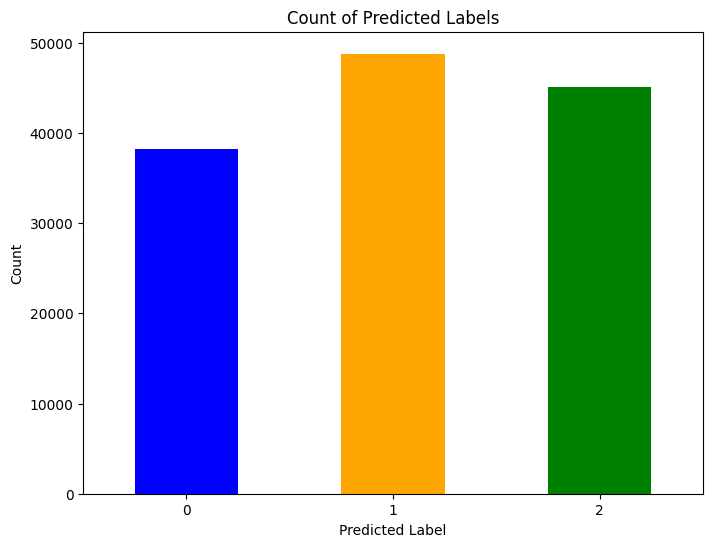

In [48]:
# Contar a quantidade de cada valor em 'predicted_label'
label_counts = df['predicted_label'].value_counts().sort_index()

# Plotar o gráfico de barras
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.xlabel('Predicted Label')
plt.ylabel('Count')
plt.title('Count of Predicted Labels')
plt.xticks(rotation=0)
plt.show()

In [49]:
df['geolocation_point'] = df['geolocation_lat'].astype(str) + ' ' + df['geolocation_lng'].astype(str)

In [50]:
df

,review_comment_message,review_score,geolocation_lat,geolocation_lng,geolocation_state,geolocation_country,origin,review_creation_date,clean_text,predicted_label,geolocation_point
0,Good. The game came in intact and new. Love th...,5,32.169732,-96.021633,TX,United States,tb_product1,2024-01-25 10:38:23.753754890,good game came intact new love game,2,32.169732 -96.021633
1,am not sure,4,38.675458,-84.902010,KY,United States,tb_product5,2024-03-27 00:53:29.249324688,am not sure,1,38.6754583 -84.9020096
2,it gets tangled so bad I cant even wear it.,1,37.289110,-122.001625,CA,United States,tb_product2,2024-05-19 16:49:07.532176664,gets tangled so bad i cant even wear,0,37.2891097 -122.0016254
3,Very nice necklace and great buy!,5,34.730924,-86.584159,AL,United States,tb_product4,2024-02-22 08:07:07.769160343,very nice necklace great buy,2,34.7309243 -86.5841592
4,Not all of the videos mentioned the connection...,1,45.426103,-105.397213,MT,United States,tb_product3,2024-01-13 01:23:00.252873389,not videos mentioned connection career math vi...,0,45.4261027 -105.3972127
...,...,...,...,...,...,...,...,...,...,...,...
132157,This is a continuation of the myst series. For...,5,34.780335,-92.394573,AR,United States,tb_product4,2024-02-12 18:19:25.142515568,is continuation myst series are best i hope ar...,2,34.7803355 -92.3945731
132158,"After playing Cata for about a month, I gave u...",4,35.942069,-82.034005,NC,United States,tb_product3,2024-03-14 23:35:13.376866095,playing cata month i gave i didnt did talent s...,1,35.9420688 -82.0340048
132159,The only reason I gave it one star is because ...,3,33.415122,-93.068499,AR,United States,tb_product3,2024-01-09 03:25:57.146208034,only reason i gave star is i couldnt figure gi...,0,33.4151216 -93.068499
132160,This was a great choice. It came with all my e...,4,47.721650,-109.225730,MT,United States,tb_product5,2024-04-05 19:33:28.668215283,was great choice came expectations more i got ...,2,47.7216499 -109.2257297


In [52]:
df.rename(columns={'predicted_label': 'predictions'}, inplace=True)
df = df.drop(columns=['clean_text'])

In [53]:
df

,review_comment_message,review_score,geolocation_lat,geolocation_lng,geolocation_state,geolocation_country,origin,review_creation_date,predictions,geolocation_point
0,Good. The game came in intact and new. Love th...,5,32.169732,-96.021633,TX,United States,tb_product1,2024-01-25 10:38:23.753754890,2,32.169732 -96.021633
1,am not sure,4,38.675458,-84.902010,KY,United States,tb_product5,2024-03-27 00:53:29.249324688,1,38.6754583 -84.9020096
2,it gets tangled so bad I cant even wear it.,1,37.289110,-122.001625,CA,United States,tb_product2,2024-05-19 16:49:07.532176664,0,37.2891097 -122.0016254
3,Very nice necklace and great buy!,5,34.730924,-86.584159,AL,United States,tb_product4,2024-02-22 08:07:07.769160343,2,34.7309243 -86.5841592
4,Not all of the videos mentioned the connection...,1,45.426103,-105.397213,MT,United States,tb_product3,2024-01-13 01:23:00.252873389,0,45.4261027 -105.3972127
...,...,...,...,...,...,...,...,...,...,...
132157,This is a continuation of the myst series. For...,5,34.780335,-92.394573,AR,United States,tb_product4,2024-02-12 18:19:25.142515568,2,34.7803355 -92.3945731
132158,"After playing Cata for about a month, I gave u...",4,35.942069,-82.034005,NC,United States,tb_product3,2024-03-14 23:35:13.376866095,1,35.9420688 -82.0340048
132159,The only reason I gave it one star is because ...,3,33.415122,-93.068499,AR,United States,tb_product3,2024-01-09 03:25:57.146208034,0,33.4151216 -93.068499
132160,This was a great choice. It came with all my e...,4,47.721650,-109.225730,MT,United States,tb_product5,2024-04-05 19:33:28.668215283,2,47.7216499 -109.2257297


In [55]:
df.to_parquet('deploycsv.parquet')

In [ ]:
import psycopg2
from sqlalchemy import create_engine

## CONFIG - POSTGRES ##
db_config = {
    'user': 'postgres',
    'password': 'admin',
    'host': 'localhost',
    'port': '5432',
    'database': 'fluffyapi'
}
conn = psycopg2.connect(**db_config)
engine = create_engine('postgresql+psycopg2://' + db_config['user'] + ':' + db_config['password'] + '@' + db_config['host'] + ':' + db_config['port'] + '/' + db_config['database'])

In [ ]:
# Substitua 'nome_da_tabela' pelo nome da tabela em seu banco de dados
nome_da_tabela = 'review'

# Inserir o DataFrame reviews no banco de dados PostgreSQL
reviews.to_sql(nome_da_tabela, engine, if_exists='append', index=False)

print("Dados inseridos com sucesso na tabela", nome_da_tabela)

Dados inseridos com sucesso na tabela review


In [ ]:
import pandas as pd
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from unicodedata import normalize
import string

# Carregar lista de stopwords em inglês
stop_words = set(stopwords.words('english'))

# Função para remover acentuações e palavras pontuadas
def preprocess_text(text):
    # Remover acentuações
    text = normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    # Remover palavras pontuadas e stopwords
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation and token.strip()]
    return ' '.join(tokens)

# Função para contar a frequência das palavras e aplicar o pré-processamento
def count_words(text):
    tokens = word_tokenize(text.lower())
    tokens = [preprocess_text(token) for token in tokens]
    return Counter(tokens)

# Filtrar o DataFrame para cada categoria de 'predictions'
predictions_0 = reviews[reviews['predictions'] == 0]['review_comment_message']
predictions_1 = reviews[reviews['predictions'] == 1]['review_comment_message']
predictions_2 = reviews[reviews['predictions'] == 2]['review_comment_message']

# Contagem de palavras e aplicação do pré-processamento para cada categoria
word_counts_0 = predictions_0.apply(count_words).sum()
word_counts_1 = predictions_1.apply(count_words).sum()
word_counts_2 = predictions_2.apply(count_words).sum()

# Selecionar as top 60 palavras mais citadas em cada categoria
top_words_0 = word_counts_0.most_common(60)
top_words_1 = word_counts_1.most_common(60)
top_words_2 = word_counts_2.most_common(60)

# Juntar os resultados em um único DataFrame
top_words_df = pd.DataFrame({
    'word': [word[0] for word in top_words_0 + top_words_1 + top_words_2],
    'counts': [word[1] for word in top_words_0 + top_words_1 + top_words_2],
    'sentiment': ['0'] * 60 + ['1'] * 60 + ['2'] * 60
})

# Exibir o DataFrame com as top 60 palavras mais citadas em cada categoria
print(top_words_df)


        word  counts sentiment
0             133827         0
1         's    2796         0
2       food    2612         0
3      order    2106         0
4    service    1883         0
..       ...     ...       ...
175     took     601         2
176      bad     592         2
177     give     579         2
178       ..     568         2
179   orders     567         2

[180 rows x 3 columns]


In [ ]:
# Substitua 'nome_da_tabela' pelo nome da tabela em seu banco de dados
nome_da_tabela = 'palavra'

# Inserir o DataFrame reviews no banco de dados PostgreSQL
top_words_df.to_sql(nome_da_tabela, engine, if_exists='append', index=False)

print("Dados inseridos com sucesso na tabela", nome_da_tabela)

Dados inseridos com sucesso na tabela palavra
